In [397]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [398]:
from pathlib import Path
import pandas as pd

# Define base paths
base_path = Path("..") / "data"
eeg_path = base_path / "eeg_raw"

# Load Stroop results
stroop_session1 = pd.read_csv(base_path / "stroop_results_1.csv")
stroop_session2 = pd.read_csv(base_path / "stroop_results_2.csv")
stroop_session3 = pd.read_csv(base_path / "stroop_results_3.csv")

# Load EEG bandpower data
eeg_session1 = pd.read_csv(eeg_path / "eeg_bandpower_session1.csv")
eeg_session2 = pd.read_csv(eeg_path / "eeg_bandpower_session2.csv")
eeg_session3 = pd.read_csv(eeg_path / "eeg_bandpower_session3.csv")

# Convert timestamps and drop missing values
for df in [
    stroop_session1, stroop_session2, stroop_session3,
    eeg_session1, eeg_session2, eeg_session3
]:
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df.dropna(inplace=True)

In [399]:
eeg_session1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86676 entries, 0 to 151211
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  86676 non-null  datetime64[ns]
 1   delta_ch0  86676 non-null  float64       
 2   theta_ch0  86676 non-null  float64       
 3   alpha_ch0  86676 non-null  float64       
 4   beta_ch0   86676 non-null  float64       
 5   gamma_ch0  86676 non-null  float64       
 6   delta_ch1  86676 non-null  float64       
 7   theta_ch1  86676 non-null  float64       
 8   alpha_ch1  86676 non-null  float64       
 9   beta_ch1   86676 non-null  float64       
 10  gamma_ch1  86676 non-null  float64       
 11  delta_ch2  86676 non-null  float64       
 12  theta_ch2  86676 non-null  float64       
 13  alpha_ch2  86676 non-null  float64       
 14  beta_ch2   86676 non-null  float64       
 15  gamma_ch2  86676 non-null  float64       
 16  delta_ch3  86676 non-null  float64       
 1

In [400]:
eeg_session2.head()

,timestamp,delta_ch0,theta_ch0,alpha_ch0,beta_ch0,gamma_ch0,delta_ch1,theta_ch1,alpha_ch1,beta_ch1,...,delta_ch3,theta_ch3,alpha_ch3,beta_ch3,gamma_ch3,delta_ch4,theta_ch4,alpha_ch4,beta_ch4,gamma_ch4
0,2025-06-12 18:34:18.490375168,24766.738474,12412.585038,8581.755537,1602.193384,722.679934,23429.474422,6992.454154,4343.887491,7365.822689,...,10910.559076,15438.079021,4771.913495,4202.839248,1241.750601,17580.129458,13375.644411,7436.871895,3957.833314,2409.539648
1,2025-06-12 18:32:51.518125056,23264.426377,13854.001338,11583.391060,2107.206574,669.554206,28886.868041,11022.876610,6015.201520,8244.335471,...,9918.613552,17653.694963,6105.184164,3921.694620,1284.927436,17837.357865,14855.008552,10444.499313,4444.642587,2501.708429
2,2025-06-12 18:34:18.474749952,20989.639178,14153.907059,13484.778761,2454.846473,560.340806,34240.654888,15240.941241,8641.899732,8554.189007,...,8999.057665,17872.324722,7066.123486,3305.420256,1213.613468,16714.369217,14865.229443,12588.319907,4545.725090,2345.365119
3,2025-06-12 18:34:19.464375040,17723.417287,13018.524358,13499.959981,2514.520111,416.804820,38022.561361,18514.585796,11720.658984,8202.987435,...,8630.915711,15904.915489,7195.221337,2498.043842,1037.924171,13737.605945,13178.159068,12927.891219,4179.633923,1982.257583
4,2025-06-12 18:34:21.924124928,13348.988520,10768.022545,11621.549687,2258.971106,277.447781,37662.931701,20147.839164,14357.048744,7289.471307,...,7408.750778,12351.674007,6402.083758,1698.910507,800.916979,10140.790709,10328.759474,11368.154229,3444.328469,1509.430950


In [401]:
def add_eeg_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add derived EEG features based on frequency bands and ratios between channels.
    Avoids division by zero by replacing 0s with a small epsilon value.
    """
    safe_cols = ['alpha_ch1', 'alpha_ch2', 'beta_ch1', 'beta_ch2']
    df[safe_cols] = df[safe_cols].replace(0, 1e-6)  # Prevent division/log errors

    # Left-right asymmetry features
    df['front_left_right_alpha_difference'] = df['alpha_ch1'] - df['alpha_ch2']
    df['front_left_right_beta_difference'] = df['beta_ch1'] - df['beta_ch2']

    # Beta/Gamma ratios for specific channels
    df['beta_gamma_ratio_ch0'] = df['beta_ch0'] / df['gamma_ch0']
    df['beta_gamma_ratio_ch1'] = df['beta_ch1'] / df['gamma_ch1']
    df['beta_gamma_ratio_ch2'] = df['beta_ch2'] / df['gamma_ch2']
    df['beta_gamma_ratio_ch3'] = df['beta_ch1'] / df['gamma_ch3']
    df['beta_gamma_ratio_ch4'] = df['beta_ch1'] / df['gamma_ch4']

    # Alpha/Beta ratio for each channel
    for ch in range(5):
        df[f'alpha_beta_ratio_ch{ch}'] = df[f'alpha_ch{ch}'] / df[f'beta_ch{ch}']

    # Frontal vs parietal beta power ratio
    df['frontal_parietal_beta_ratio'] = (df['beta_ch1'] + df['beta_ch2']) / (df['beta_ch0'] + df['beta_ch3'])

    return df


def merge_eeg_results(results_df: pd.DataFrame, eeg_df: pd.DataFrame) -> pd.DataFrame:
    """
    Align EEG data with behavioral results by slicing EEG windows between trials.
    Each EEG row is annotated with the trial metadata it belongs to.
    """
    results_df = results_df.sort_values('timestamp').reset_index(drop=True)
    results_df['prev_timestamp'] = results_df['timestamp'].shift(1)
    results_df = results_df.dropna(subset=['prev_timestamp'])

    rows = []
    for _, row in results_df.iterrows():
        eeg_slice = eeg_df[
            (eeg_df['timestamp'] >= row['prev_timestamp']) &
            (eeg_df['timestamp'] < row['timestamp'])
        ].copy()

        # Attach trial metadata to each EEG row in the slice
        eeg_slice[['trial', 'word', 'color', 'response', 'correct', 'response_time']] = row[
            ['trial', 'word', 'color', 'response', 'correct', 'response_time']
        ]
        rows.append(eeg_slice)

    return pd.concat(rows, ignore_index=True)


def center_columns_by_mean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Subtracts the mean from each numeric column in the DataFrame,
    excluding the 'timestamp' column, and returns the centered DataFrame.
    """
    if 'timestamp' not in df.columns:
        raise ValueError("DataFrame must contain a 'timestamp' column.")

    df_numeric = df.drop(columns=['timestamp'])
    df_centered = df_numeric - df_numeric.mean()

    # Reinsert timestamp column as the first column
    df_centered['timestamp'] = df['timestamp']
    df_centered = df_centered[['timestamp'] + [col for col in df_centered.columns if col != 'timestamp']]

    return df_centered

In [402]:
# Center EEG features by removing mean from each numeric column (excluding timestamp)
eeg_session2 = center_columns_by_mean(eeg_session2)
eeg_session3 = center_columns_by_mean(eeg_session3)
eeg_session1 = center_columns_by_mean(eeg_session1)

# Merge EEG and Stroop results, then engineer features
train_df_1 = add_eeg_features(merge_eeg_results(stroop_session3, eeg_session3))
train_df_2 = add_eeg_features(merge_eeg_results(stroop_session1, eeg_session1))
train_df = pd.concat([train_df_1, train_df_2], axis=0, ignore_index=True)

test_df = add_eeg_features(merge_eeg_results(stroop_session2, eeg_session2))

# === Grade Calculation Settings ===
base_score = 1.0
bonus_factor = 1.0        # Reward fast responses more
incorrect_factor = 0      # No credit for incorrect answers

# Prepare X and y for train/test
X_train = train_df.drop(columns=["response_time", "correct"])
y_train = train_df[["response_time", "correct"]].copy()

X_test = test_df.drop(columns=["response_time", "correct"])
y_test = test_df[["response_time", "correct"]].copy()

# === Step 1: Calculate mean and std of response time on training set ===
mean_rt = y_train["response_time"].mean()
std_rt = y_train["response_time"].std()

# === Step 2: Define scoring function ===
def compute_raw_grade(row):
    z_score = (row["response_time"] - mean_rt) / std_rt
    fast_bonus = -z_score * bonus_factor
    correctness_score = 1.0 if row["correct"] else incorrect_factor
    return base_score * correctness_score + fast_bonus

# Apply to training data
y_train["raw_grade"] = y_train.apply(compute_raw_grade, axis=1)

# === Step 3: Normalize grades to [0, 1] ===
min_grade_train = y_train["raw_grade"].min()
max_grade_train = y_train["raw_grade"].max()

y_train["norm_grade"] = (
    (y_train["raw_grade"] - min_grade_train) / (max_grade_train - min_grade_train)
)

# Apply to test data using same scoring
y_test["raw_grade"] = y_test.apply(compute_raw_grade, axis=1)

min_grade_test = y_test["raw_grade"].min()
max_grade_test = y_test["raw_grade"].max()

y_test["norm_grade"] = (
    (y_test["raw_grade"] - min_grade_test) / (max_grade_test - min_grade_test)
)

# Drop unnecessary columns and keep only target
y_train = y_train.drop(columns=["raw_grade", "correct", "response_time"])
y_test = y_test.drop(columns=["raw_grade", "correct", "response_time"])

# Final filtering of numeric columns in X
X_train = X_train.select_dtypes(include=[float, int])
X_test = X_test.select_dtypes(include=[float, int])

# Sanity check
print(y_test.head())


   norm_grade
0    0.739146
1    0.739146
2    0.739146
3    0.739146
4    0.739146


In [403]:
X_train.head()

,delta_ch0,theta_ch0,alpha_ch0,beta_ch0,gamma_ch0,delta_ch1,theta_ch1,alpha_ch1,beta_ch1,gamma_ch1,...,beta_gama_ratio_ch1,beta_gama_ratio_ch2,beta_gama_ratio_ch3,beta_gama_ratio_ch4,alph_beta_ratio_ch0,alph_beta_ratio_ch1,alph_beta_ratio_ch2,alph_beta_ratio_ch3,alph_beta_ratio_ch4,frontal_parietal_beta_ratio
0,-694.478285,-629.194638,-448.164531,-93.812870,-6.385563,24931.194257,-4436.812505,-3680.264491,147.488366,-373.197863,...,-0.395202,1.166124,-8.809882,-0.709114,4.777218,-24.952914,8.461589,4.932717,9.418278,0.022345
1,-878.443030,-689.261307,-450.076599,-99.899804,-4.898580,8636.344804,-3448.421755,-697.441482,-492.492101,20.759551,...,-23.723639,0.696069,20.763801,4.413027,4.505280,1.416148,4.388214,4.495684,6.514109,3.951473
2,2918.182386,5790.008513,2852.664798,595.329986,182.642172,21019.803463,5400.940870,6553.020134,2223.867464,-1251.492155,...,-1.776973,-2.075298,15.831654,2.634816,4.791737,2.946677,8.723472,5.173169,1.258452,2.581285
3,29451.500569,13819.783613,2008.266798,779.585452,235.961533,7708.084807,24606.346396,-1158.721336,4812.618202,-2444.237845,...,-1.968965,-0.328403,14.143152,3.963316,2.576070,-0.240767,14.233562,0.660712,0.530533,2.379830
4,26174.998909,4318.793922,1546.293753,236.373467,95.961686,9740.247555,5060.770609,-1551.740814,-324.190481,-3484.682074,...,0.093033,-0.453769,-0.376702,-12.364451,6.541740,4.786509,12.813245,0.474632,-789.563377,-0.058805


In [405]:
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

# === Step 3: Train XGBoost regression model ===
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)

# === Step 4: Predict on test set and evaluate performance ===
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"📈 R² score: {r2:.4f}")


✅ RMSE: 0.1737


In [406]:
X_test.info()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86544 entries, 0 to 86543
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   delta_ch0                        86544 non-null  float64
 1   theta_ch0                        86544 non-null  float64
 2   alpha_ch0                        86544 non-null  float64
 3   beta_ch0                         86544 non-null  float64
 4   gamma_ch0                        86544 non-null  float64
 5   delta_ch1                        86544 non-null  float64
 6   theta_ch1                        86544 non-null  float64
 7   alpha_ch1                        86544 non-null  float64
 8   beta_ch1                         86544 non-null  float64
 9   gamma_ch1                        86544 non-null  float64
 10  delta_ch2                        86544 non-null  float64
 11  theta_ch2                        86544 non-null  float64
 12  alpha_ch2         

In [407]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# === Define models to compare ===
models = {
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    ),
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

# === Train, predict, and evaluate each model ===
results = []

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"📊 Model: {name}")
    print(f"   ✅ RMSE: {rmse:.4f}")
    print(f"   📈 R² Score: {r2:.4f}\n")

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R² Score": r2
    })

# === Display results as sorted DataFrame ===
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n🔍 Model Comparison Summary:")
print(results_df)

Model:  XGBoost
RMSE:  0.1737098494153974
Model:  Linear Regression
RMSE:  0.16799251541678253
Model:  Ridge
RMSE:  0.16799251542461835
Model:  Lasso
RMSE:  0.1690728256628221
               Model      RMSE  R² Score
1  Linear Regression  0.167993 -0.267217
2              Ridge  0.167993 -0.267217
3              Lasso  0.169073 -0.283568
0            XGBoost  0.173710 -0.354940


In [410]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# === Define the final model with tuned hyperparameters ===
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    subsample=1.0,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.15,
    colsample_bytree=1.0,
    random_state=42
)

# === Train model on full training data ===
best_model.fit(X_train, y_train.values.ravel())

# === Predict on test set ===
y_pred = best_model.predict(X_test)

# === Evaluate model performance ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Final RMSE: {rmse:.4f}")

# === Save model to disk ===
best_model.save_model("xgb_model.json")
print("💾 Model saved to: xgb_model.json")


✅ Final RMSE: 0.1660


In [411]:
# === Combine X_test, y_test, and model predictions into a single DataFrame ===
combined_df = pd.concat([
    X_test.reset_index(drop=True),
    y_test.reset_index(drop=True),
    pd.DataFrame({'y_pred': y_pred})
], axis=1)

# Preview the combined data
combined_df.head()


,delta_ch0,theta_ch0,alpha_ch0,beta_ch0,gamma_ch0,delta_ch1,theta_ch1,alpha_ch1,beta_ch1,gamma_ch1,...,beta_gama_ratio_ch3,beta_gama_ratio_ch4,alph_beta_ratio_ch0,alph_beta_ratio_ch1,alph_beta_ratio_ch2,alph_beta_ratio_ch3,alph_beta_ratio_ch4,frontal_parietal_beta_ratio,norm_grade,y_pred
0,-2870.824941,-725.963113,-177.312604,-43.448152,-8.170011,183810.809923,3476.509322,-695.298880,-210.589745,-166.685430,...,30.031739,0.368199,4.081016,3.301675,3.861274,4.897478,1.004290,3.320413,0.739146,0.827763
1,-2868.574755,-725.216595,-177.331644,-43.456457,-8.183269,183519.542400,3432.833974,-696.065233,-213.995024,-162.301922,...,30.474988,0.373751,4.080674,3.252717,3.894724,4.897425,1.003747,3.365294,0.739146,0.827763
2,-2867.114405,-724.515455,-177.355756,-43.464722,-8.196374,183348.531203,3387.366167,-696.705408,-217.135340,-157.714599,...,30.878725,0.378826,4.080453,3.208623,3.928167,4.897377,1.003188,3.406929,0.739146,0.827763
3,-2866.649578,-723.860630,-177.384869,-43.472939,-8.209313,183138.654957,3340.184609,-697.203036,-220.000539,-152.922386,...,31.241705,0.383409,4.080351,3.169097,3.961588,4.897335,1.002616,3.445184,0.739146,0.827838
4,-2866.173959,-723.252985,-177.418887,-43.481102,-8.222073,182892.837650,3291.366825,-697.541441,-222.581012,-147.924568,...,31.562779,0.387485,4.080368,3.133877,3.994985,4.897295,1.002033,3.479933,0.739146,0.826377


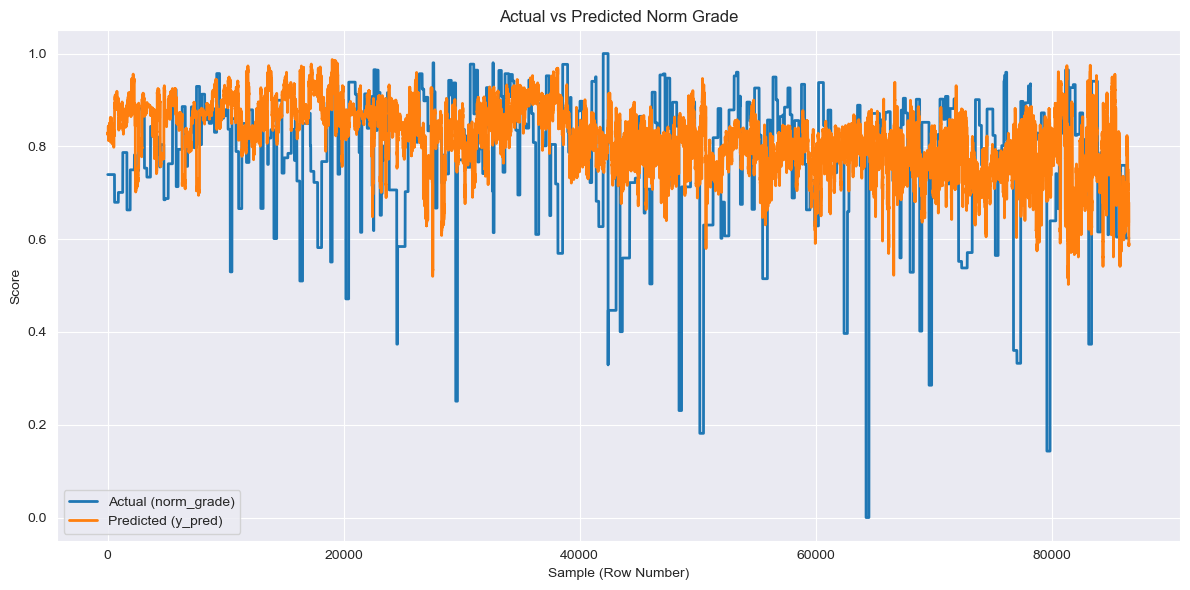

In [412]:
import matplotlib.pyplot as plt

# === Plot actual vs predicted normalized grades ===
plt.figure(figsize=(12, 6))

plt.plot(
    combined_df.index,
    combined_df['norm_grade'],
    label='Actual (norm_grade)',
    linewidth=2
)
plt.plot(
    combined_df.index,
    combined_df['y_pred'],
    label='Predicted (y_pred)',
    linewidth=2
)

plt.xlabel("Sample Index")
plt.ylabel("Normalized Score")
plt.title("Actual vs Predicted Norm Grade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


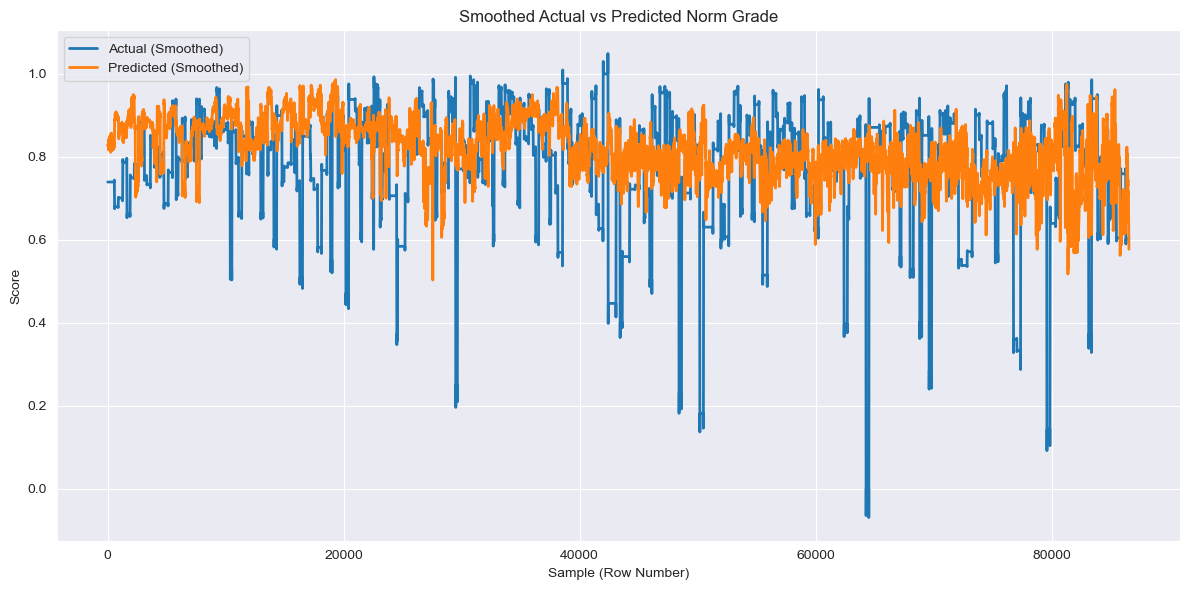

In [413]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# === Apply Savitzky-Golay smoothing to actual and predicted curves ===
window_size = 31       # Must be odd and smaller than the length of the data
poly_order = 2         # Degree of the smoothing polynomial

y_actual_smooth = savgol_filter(
    combined_df['norm_grade'], window_length=window_size, polyorder=poly_order
)
y_pred_smooth = savgol_filter(
    combined_df['y_pred'], window_length=window_size, polyorder=poly_order
)

# === Plot smoothed curves ===
plt.figure(figsize=(12, 6))
plt.plot(
    combined_df.index,
    y_actual_smooth,
    label='Actual (Smoothed)',
    linewidth=2
)
plt.plot(
    combined_df.index,
    y_pred_smooth,
    label='Predicted (Smoothed)',
    linewidth=2
)

plt.xlabel("Sample Index")
plt.ylabel("Normalized Score")
plt.title("Smoothed Actual vs Predicted Norm Grade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [414]:
# === Merge EEG and Stroop data for session 3 ===
merged_session3 = merge_eeg_results(stroop_session3, eeg_session3)

# === Scoring settings ===
base_score = 1.0
bonus_factor = 1.0       # Reward faster responses more
incorrect_factor = 0     # No credit for incorrect answers

# === Step 1: Compute mean and standard deviation of response times ===
mean_rt = stroop_session3["response_time"].mean()
std_rt = stroop_session3["response_time"].std()

# === Step 2: Compute raw score for each trial ===
def compute_raw_grade(row):
    z_score = (row["response_time"] - mean_rt) / std_rt
    fast_bonus = -z_score * bonus_factor
    correctness_score = 1.0 if row["correct"] else incorrect_factor
    return base_score * correctness_score + fast_bonus

stroop_session3["raw_grade"] = stroop_session3.apply(compute_raw_grade, axis=1)

# === Step 3: Normalize raw grades to [0, 1] ===
min_grade = stroop_session3["raw_grade"].min()
max_grade = stroop_session3["raw_grade"].max()

stroop_session3["norm_grade"] = (
    (stroop_session3["raw_grade"] - min_grade) / (max_grade - min_grade)
)

# Preview result
stroop_session3.head()

,trial,timestamp,word,color,response,correct,response_time,raw_grade,norm_grade
0,0,2025-06-12 18:34:30.093729536,GREEN,yellow,yellow,True,5.787026,-9.483392,0.000000
1,1,2025-06-12 18:34:35.887743232,BLUE,blue,blue,True,1.102082,0.636138,0.860796
2,2,2025-06-12 18:34:36.994824448,YELLOW,yellow,yellow,True,0.798688,1.291472,0.916541
3,3,2025-06-12 18:34:37.797519616,GREEN,green,green,True,0.899094,1.074595,0.898093
4,4,2025-06-12 18:34:38.700611328,RED,red,red,True,0.941853,0.982235,0.890236


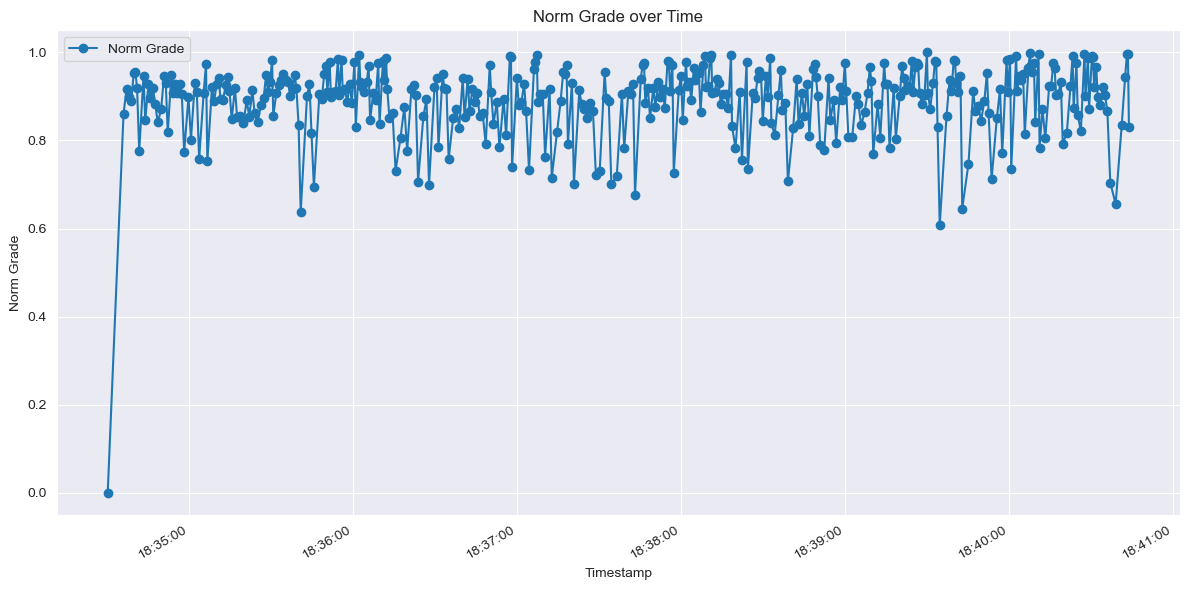

In [415]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Ensure timestamp is in datetime format ===
stroop_session3["timestamp"] = pd.to_datetime(stroop_session3["timestamp"])

# Sort data by timestamp (just to be safe)
stroop_session3 = stroop_session3.sort_values(by="timestamp")

# === Plot norm grade over time ===
plt.figure(figsize=(12, 6))
plt.plot(
    stroop_session3["timestamp"],
    stroop_session3["norm_grade"],
    marker='o',
    linestyle='-',
    linewidth=1.5,
    label="Norm Grade"
)

# Format x-axis to show time only (HH:MM:SS)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.xlabel("Timestamp")
plt.ylabel("Normalized Grade")
plt.title("Norm Grade Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
